# Reproduce Staley (2016) Results

Based on the calculations in the USGS Emergency Debris Flow Assessment database (https://landslides.usgs.gov/hazards/postfire_debrisflow/), the Intensity I15 is transformed into the total accumulation during the 15 minutes, i.e. I15/4.  This is the same as the value stored in the column "Acc015_mm".

In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [2]:
import pandas as pd
pd.set_option("max_colwidth", None)

In [3]:
import numpy as np

In [4]:
xl=pd.ExcelFile("../../data/ofr20161106_appx-1.xlsx")
desc=xl.parse(xl.sheet_names[0])
modelData=xl.parse(xl.sheet_names[1])

In [5]:
modelData.columns

Index(['Fire Name', 'Year', 'Fire_ID', 'Fire_SegID', 'Database', 'State',
       'UTM_Zone', 'UTM_X', 'UTM_Y', 'Response', 'StormDate', 'GaugeDist_m',
       'StormStart', 'StormEnd', 'StormDur_H', 'StormAccum_mm',
       'StormAvgI_mm/h', 'Peak_I15_mm/h', 'Peak_I30_mm/h', 'Peak_I60_mm/h',
       'ContributingArea_km2', 'PropHM23', 'dNBR/1000', 'KF', 'Acc015_mm',
       'Acc030_mm', 'Acc060_mm'],
      dtype='object')

In [6]:
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

In [7]:
def get_scores(trues, preds):
    scores=[func(trues, preds) for func in [accuracy_score, jaccard_score, f1_score, roc_auc_score]]
    return scores

def get_scoredf(TrTr, TrPr, TeTr, TePr):
    train_scores=get_scores(TrTr, TrPr)
    test_scores=get_scores(TeTr, TePr)
    
    scoredf=pd.DataFrame({"Training": train_scores, "Test": test_scores}, index=["Accurary", "Jaccard", "F1", "AUC"])
    return scoredf

In [8]:
modelData.columns

Index(['Fire Name', 'Year', 'Fire_ID', 'Fire_SegID', 'Database', 'State',
       'UTM_Zone', 'UTM_X', 'UTM_Y', 'Response', 'StormDate', 'GaugeDist_m',
       'StormStart', 'StormEnd', 'StormDur_H', 'StormAccum_mm',
       'StormAvgI_mm/h', 'Peak_I15_mm/h', 'Peak_I30_mm/h', 'Peak_I60_mm/h',
       'ContributingArea_km2', 'PropHM23', 'dNBR/1000', 'KF', 'Acc015_mm',
       'Acc030_mm', 'Acc060_mm'],
      dtype='object')

In [9]:
usecols=["Acc015_mm",
         "PropHM23",
         "dNBR/1000",
         "KF",
         "Response"]

usecols = usecols + ["Database"]

In [10]:
cdata=modelData[usecols].copy()
cdata=cdata.dropna()
len(cdata)

1243

Adjusting unrealistic $K_f$ values - commented out, as it's not sure if Staley did this:

In [11]:
#mask=cdata["KF"] > 0.64
#cdata.loc[mask,"KF"] = cdata["KF"].median()

In [12]:
#computing input data just as in Staley'16

cdata["PropHM23_x_i15"] = cdata["PropHM23"] * cdata["Acc015_mm"]
cdata["dNBR_x_i15"] = cdata["dNBR/1000"] * cdata["Acc015_mm"]
cdata["KF_x_i15"] = cdata["KF"] * cdata["Acc015_mm"]

In [13]:
usecols2=["PropHM23_x_i15","dNBR_x_i15", "KF_x_i15"]

In [14]:
cdata

,Acc015_mm,PropHM23,dNBR/1000,KF,Response,Database,PropHM23_x_i15,dNBR_x_i15,KF_x_i15
0,0.80,0.217933,0.297853,0.250000,0,Training,0.174346,0.238282,0.200000
1,0.80,0.061249,0.224896,0.250000,0,Training,0.048999,0.179916,0.200000
2,0.80,0.042968,0.065537,0.248541,0,Training,0.034374,0.052430,0.198832
3,0.40,0.092164,0.141711,0.250000,0,Training,0.036866,0.056684,0.100000
4,0.40,0.058353,0.210158,0.250000,0,Training,0.023341,0.084063,0.100000
...,...,...,...,...,...,...,...,...,...
1545,3.50,0.009801,0.187053,0.000000,0,Test,0.034302,0.654684,0.000000
1546,15.75,0.001571,0.500223,0.000000,0,Test,0.024740,7.878512,0.000000
1547,7.25,0.001571,0.500223,0.000000,0,Test,0.011388,3.626616,0.000000
1548,6.25,0.001571,0.500223,0.000000,0,Test,0.009817,3.126394,0.000000


In [15]:
cdata['Database'].value_counts(normalize=True)

Training    0.655672
Test        0.344328
Name: Database, dtype: float64

In [16]:
# Split based on Staley criteria (SoCal train)

trainX=cdata.query("Database == 'Training'")[usecols2]
trainY=cdata.query("Database == 'Training'")["Response"]

testX=cdata.query("Database == 'Test'")[usecols2]
testY=cdata.query("Database == 'Test'")["Response"]

In [17]:
# random split training and test data

feat_data = cdata[usecols2]
target_data = cdata["Response"]

X_train, X_test, y_train, y_test = train_test_split(feat_data, 
                                                    target_data,
                                                    test_size=.34, # corresponds to staley proportion
                                                    random_state=seed
                                                   )

### 1. Logistic Regression

In [18]:
# SoCal train

# instantiate and fit model on training data
clfl = LogisticRegression(random_state=seed, penalty='l2').fit(trainX, trainY)

# train prediction
lr_trainYp=clfl.predict(trainX)

# test predict
lr_testYp=clfl.predict(testX)

# assess model
scoredf_lr=get_scoredf(trainY, lr_trainYp, testY, lr_testYp)
scoredf_lr

,Training,Test
Accurary,0.833129,0.647196
Jaccard,0.411255,0.386179
F1,0.582822,0.557185
AUC,0.711888,0.703778


In [19]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst = LogisticRegression(random_state=seed, penalty='l2').fit(X_train, y_train)

# predict training data
lr_trainYp_rst=clfl_rst.predict(X_train)

# predict testing data
lr_testYp_rst=clfl_rst.predict(X_test)

# assess model
scoredf_lr_rst=get_scoredf(y_train, lr_trainYp_rst, y_test, lr_testYp_rst)
scoredf_lr_rst

,Training,Test
Accurary,0.759756,0.728132
Jaccard,0.179167,0.178571
F1,0.303887,0.303030
AUC,0.576682,0.565713


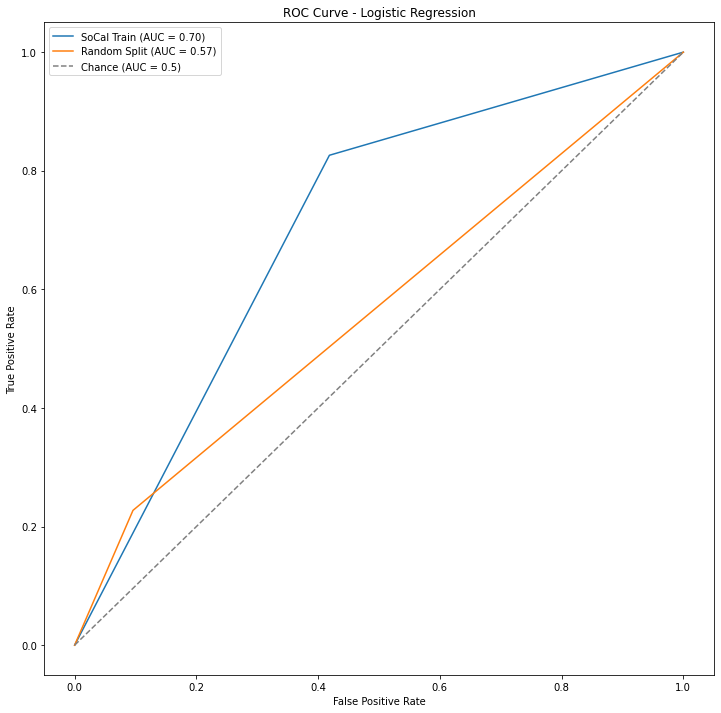

In [20]:
# Calculate ROC curve and AUC

#SoCal
lr_fpr, lr_tpr, _ = roc_curve(testY, lr_testYp, drop_intermediate=False)
lr_auc = auc(lr_fpr, lr_tpr)

#Random Split
lr_fpr_rst, lr_tpr_rst, _ = roc_curve(y_test, lr_testYp_rst, drop_intermediate=False)
lr_auc_rst = auc(lr_fpr_rst, lr_tpr_rst)

# Plot ROC curve
plt.figure(figsize=(12, 12))
#SoCal
plt.plot(lr_fpr, lr_tpr, label=f'SoCal Train (AUC = {lr_auc:.2f})')
#RST
plt.plot(lr_fpr_rst, lr_tpr_rst, label=f'Random Split (AUC = {lr_auc_rst:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

### 2.  Random Forest Classifier

In [21]:
# SoCal Train

# instantiate and fit model on training data
clfl = RandomForestClassifier(random_state=seed).fit(trainX, trainY)

# train prediction
rf_trainYp=clfl.predict(trainX)

# test predict
rf_testYp=clfl.predict(testX)

# assess model
scoredf_rf=get_scoredf(trainY, rf_trainYp, testY, rf_testYp)
scoredf_rf

,Training,Test
Accurary,1.0,0.591121
Jaccard,1.0,0.347015
F1,1.0,0.515235
AUC,1.0,0.659939


In [22]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst = RandomForestClassifier(random_state=seed).fit(X_train, y_train)

# predict training data
rf_trainYp_rst=clfl_rst.predict(X_train)

# predict testing data
rf_testYp_rst=clfl_rst.predict(X_test)

# assess model
scoredf_rf_rst=get_scoredf(y_train, rf_trainYp_rst, y_test, rf_testYp_rst)
scoredf_rf_rst

,Training,Test
Accurary,0.998780,0.801418
Jaccard,0.995169,0.408451
F1,0.997579,0.580000
AUC,0.999186,0.712518


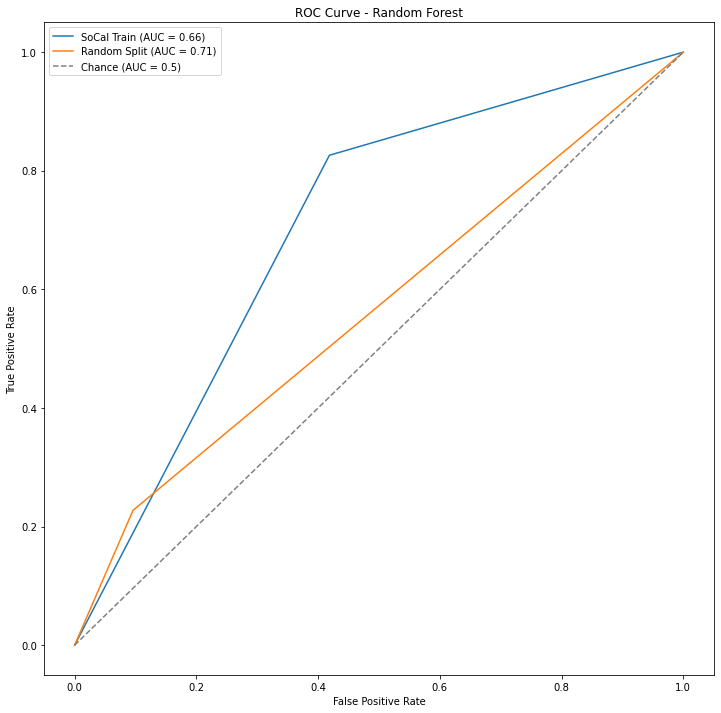

In [23]:
# Calculate ROC curve and AUC

#SoCal
rf_fpr, rf_tpr, _ = roc_curve(testY, rf_testYp, drop_intermediate=False)
rf_auc = auc(rf_fpr, rf_tpr)

#Random Split
rf_fpr_rst, rf_tpr_rst, _ = roc_curve(y_test, rf_testYp_rst, drop_intermediate=False)
rf_auc_rst = auc(rf_fpr_rst, rf_tpr_rst)

# Plot ROC curve
plt.figure(figsize=(12, 12))
#SoCal
plt.plot(lr_fpr, lr_tpr, label=f'SoCal Train (AUC = {rf_auc:.2f})')
#RST
plt.plot(lr_fpr_rst, lr_tpr_rst, label=f'Random Split (AUC = {rf_auc_rst:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

### 3. KNeighbors Classifier

In [24]:
# SoCal Train

# instantiate and fit model on training data
clfl = KNeighborsClassifier().fit(trainX, trainY)

# train prediction
knn_trainYp=clfl.predict(trainX)

# test predict
knn_testYp=clfl.predict(testX)

# assess model
scoredf_knn=get_scoredf(trainY, knn_trainYp, testY, knn_testYp)
scoredf_knn

,Training,Test
Accurary,0.871166,0.600467
Jaccard,0.556962,0.337209
F1,0.715447,0.504348
AUC,0.799042,0.649826


In [25]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst = KNeighborsClassifier().fit(X_train, y_train)

# predict training data
knn_trainYp_rst=clfl_rst.predict(X_train)

# predict testing data
knn_testYp_rst=clfl_rst.predict(X_test)

# assess model
scoredf_knn_rst=get_scoredf(y_train, knn_trainYp_rst, y_test, knn_testYp_rst)
scoredf_knn_rst

,Training,Test
Accurary,0.837805,0.758865
Jaccard,0.480469,0.341935
F1,0.649077,0.509615
AUC,0.757827,0.669024


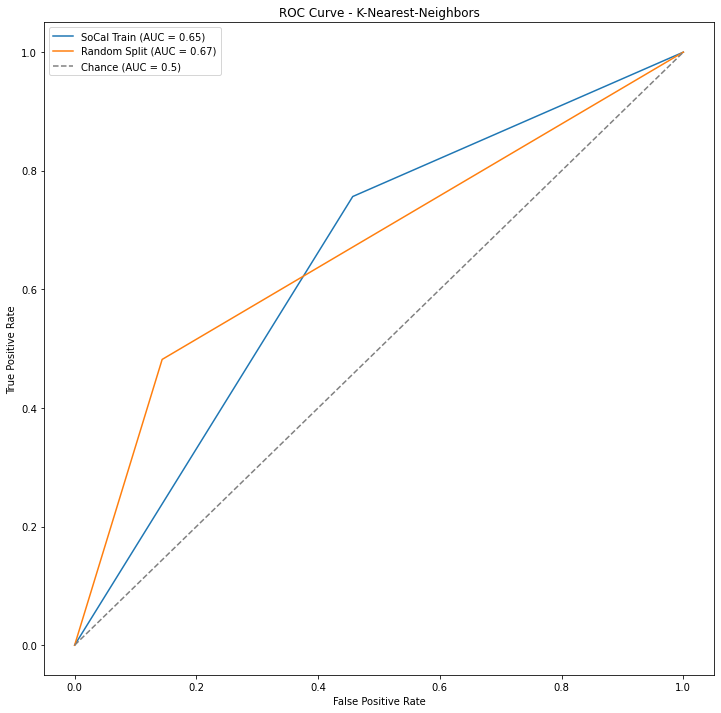

In [26]:
# Calculate ROC curve and AUC

#SoCal
knn_fpr, knn_tpr, _ = roc_curve(testY, knn_testYp, drop_intermediate=False)
knn_auc = auc(knn_fpr, knn_tpr)

#Random Split
knn_fpr_rst, knn_tpr_rst, _ = roc_curve(y_test, knn_testYp_rst, drop_intermediate=False)
knn_auc_rst = auc(knn_fpr_rst, knn_tpr_rst)

# Plot ROC curve
plt.figure(figsize=(12, 12))
#SoCal
plt.plot(knn_fpr, knn_tpr, label=f'SoCal Train (AUC = {knn_auc:.2f})')
#RST
plt.plot(knn_fpr_rst, knn_tpr_rst, label=f'Random Split (AUC = {knn_auc_rst:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-Nearest-Neighbors')
plt.legend()
plt.show()

### 4. Decision Tree Classifier

In [27]:
# SoCal Train

# instantiate and fit model on training data
clfl = DecisionTreeClassifier(random_state=seed).fit(trainX, trainY)

# train prediction
dt_trainYp=clfl.predict(trainX)
# test predict
dt_testYp=clfl.predict(testX)

# assess model
scoredf_dt=get_scoredf(trainY, dt_trainYp, testY, dt_testYp)
scoredf_dt

,Training,Test
Accurary,1.0,0.518692
Jaccard,1.0,0.304054
F1,1.0,0.466321
AUC,1.0,0.602167


In [28]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst = DecisionTreeClassifier(random_state=seed).fit(X_train, y_train)

# predict training data
dt_trainYp_rst=clfl_rst.predict(X_train)

# predict testing data
dt_testYp_rst=clfl_rst.predict(X_test)

# assess model
scoredf_dt_rst=get_scoredf(y_train, dt_trainYp_rst, y_test, dt_testYp_rst)
scoredf_dt_rst

,Training,Test
Accurary,0.998780,0.803783
Jaccard,0.995146,0.427586
F1,0.997567,0.599034
AUC,0.997573,0.725908


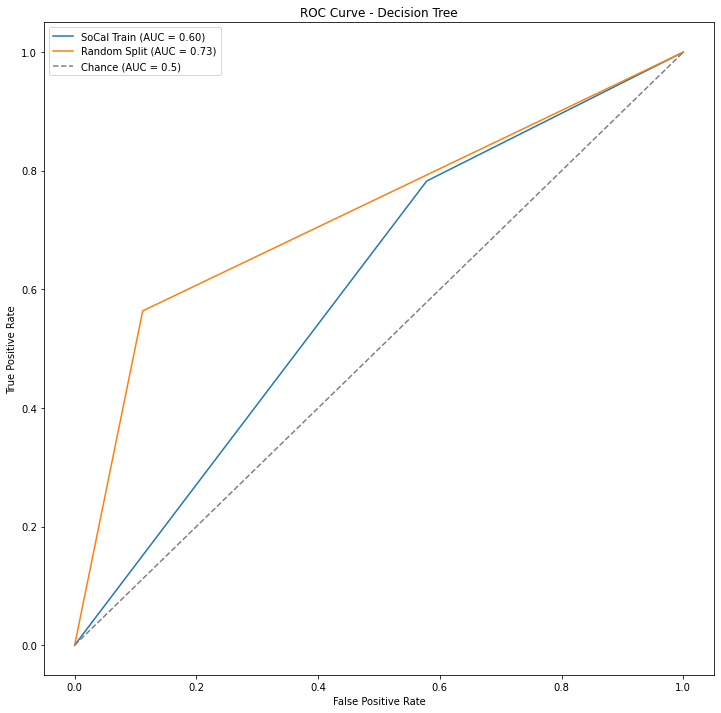

In [29]:
# Calculate ROC curve and AUC

#SoCal
dt_fpr, dt_tpr, _ = roc_curve(testY, dt_testYp, drop_intermediate=False)
dt_auc = auc(dt_fpr, dt_tpr)

#Random Split
dt_fpr_rst, dt_tpr_rst, _ = roc_curve(y_test, dt_testYp_rst, drop_intermediate=False)
dt_auc_rst = auc(dt_fpr_rst, dt_tpr_rst)

# Plot ROC curve
plt.figure(figsize=(12, 12))
#SoCal
plt.plot(dt_fpr, dt_tpr, label=f'SoCal Train (AUC = {dt_auc:.2f})')
#RST
plt.plot(dt_fpr_rst, dt_tpr_rst, label=f'Random Split (AUC = {dt_auc_rst:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.show()

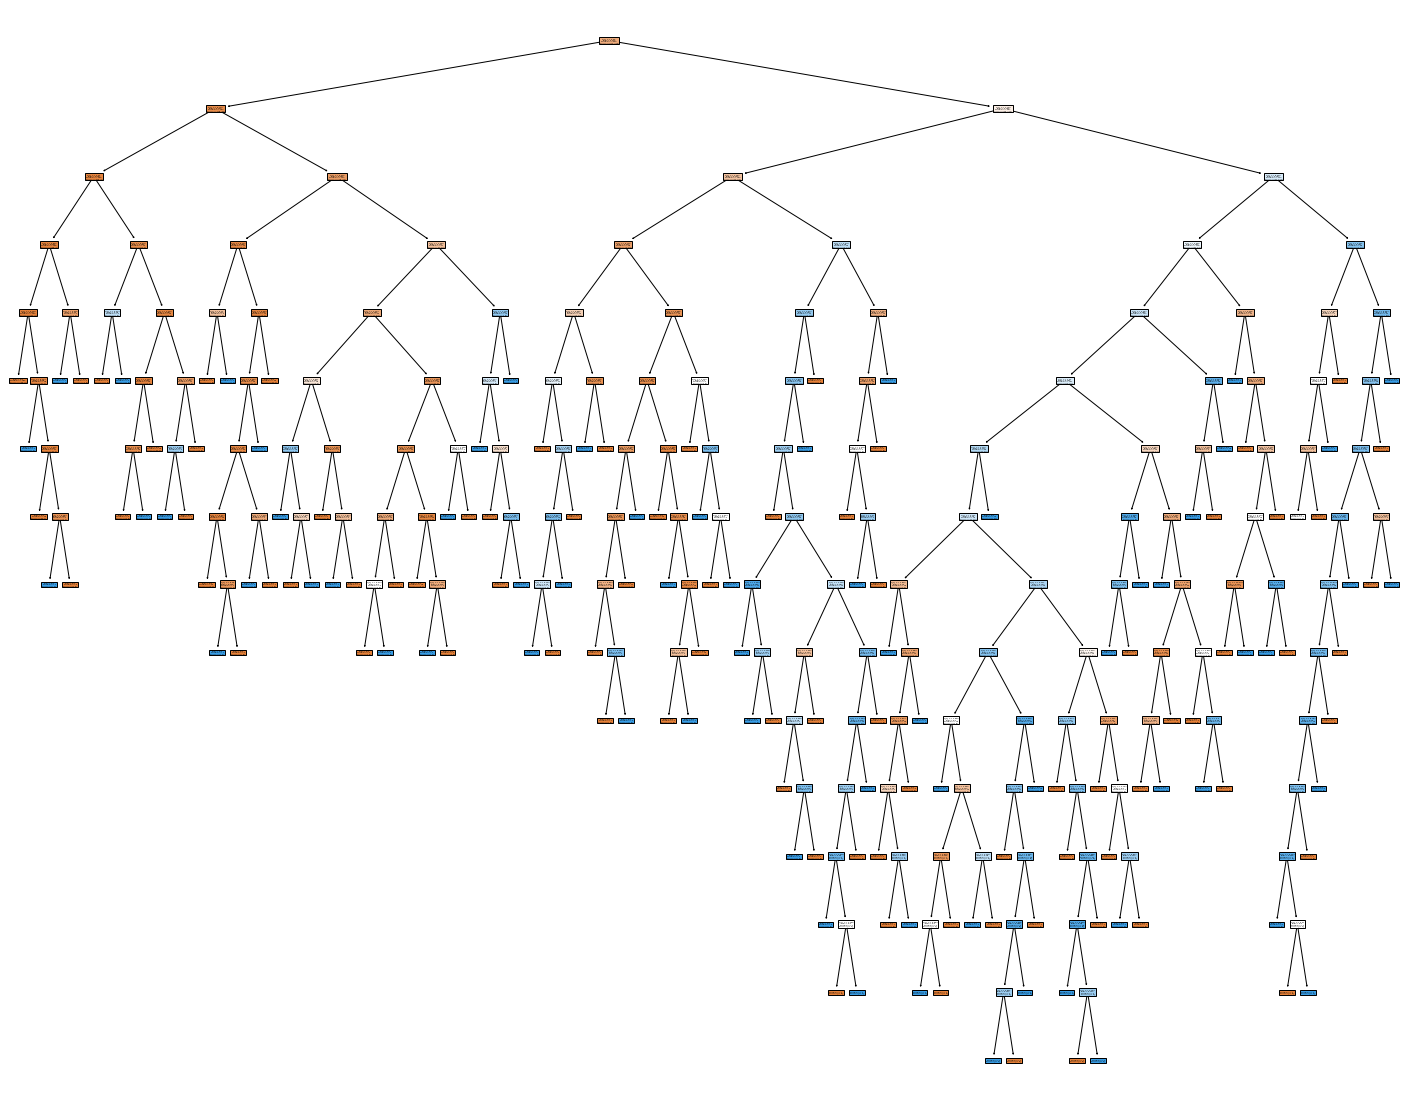

In [30]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfl_rst,
                  #feature_names=usecols2,
                   #class_names=["0","1"],
                   filled=True
                  )

### 5. Neural Network

In [31]:
# SoCal Train

# instantiate and fit model on training data
clfl = MLPClassifier(hidden_layer_sizes=(30, 30, 30), max_iter=1000).fit(trainX, trainY)

# train prediction
nn_trainYp=clfl.predict(trainX)

# test predict
nn_testYp=clfl.predict(testX)

# assess model
scoredf_nn=get_scoredf(trainY, nn_trainYp, testY, nn_testYp)
scoredf_nn

,Training,Test
Accurary,0.844172,0.612150
Jaccard,0.442982,0.351562
F1,0.613982,0.520231
AUC,0.729257,0.666065


In [32]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst = MLPClassifier(hidden_layer_sizes=(30, 30, 30), max_iter=1000).fit(X_train, y_train)

# predict training data
nn_trainYp_rst=clfl_rst.predict(X_train)

# predict testing data
nn_testYp_rst=clfl_rst.predict(X_test)

# assess model
scoredf_nn_rst=get_scoredf(y_train, nn_trainYp_rst, y_test, nn_testYp_rst)
scoredf_nn_rst

,Training,Test
Accurary,0.806098,0.742317
Jaccard,0.415441,0.322981
F1,0.587013,0.488263
AUC,0.720526,0.654894


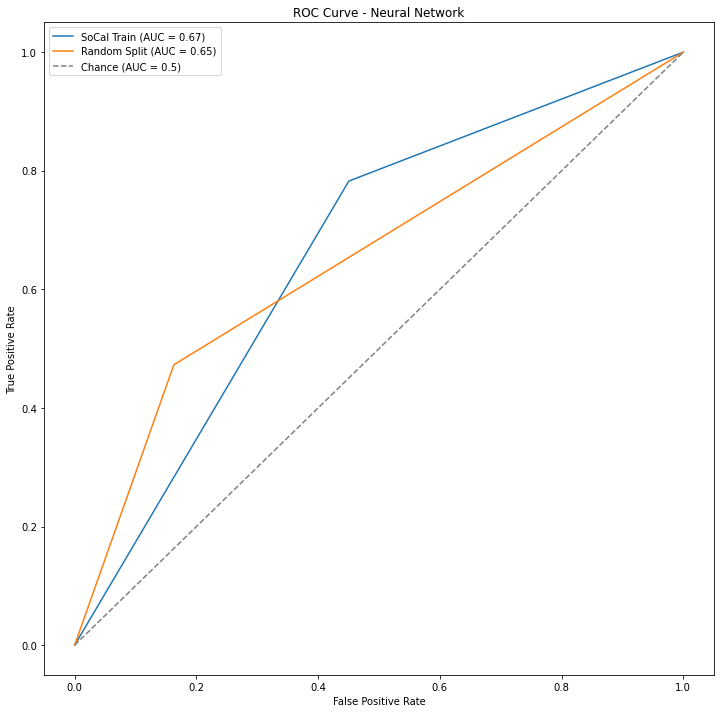

In [33]:
# Calculate ROC curve and AUC

#SoCal
nn_fpr, nn_tpr, _ = roc_curve(testY, nn_testYp, drop_intermediate=False)
nn_auc = auc(nn_fpr, nn_tpr)

#Random Split
nn_fpr_rst, nn_tpr_rst, _ = roc_curve(y_test, nn_testYp_rst, drop_intermediate=False)
nn_auc_rst = auc(nn_fpr_rst, nn_tpr_rst)

# Plot ROC curve
plt.figure(figsize=(12, 12))
#SoCal
plt.plot(nn_fpr, nn_tpr, label=f'SoCal Train (AUC = {nn_auc:.2f})')
#RST
plt.plot(nn_fpr_rst, nn_tpr_rst, label=f'Random Split (AUC = {nn_auc_rst:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.show()